In [1]:
import pandas as pd 
import json
import glob
pd.set_option("display.max_columns",100)
import subprocess
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import json
from nltk.tokenize import TweetTokenizer
from unidecode import unidecode as unidec
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from econtools.metrics import reg
from datetime import timedelta
string.punctuation

# This maketrans function can be used to remove a list of characters from a string.
remv_punc = str.maketrans('','',string.punctuation)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jhtchns2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
dir_ = "../../Data/Text/"

# <center> A Twitter Case Study: The Doge Coin Bubble </center>

<center>
<img src="doge.jpg" height=20>
</center>

### For the uninformed, this is how it started:
- Some years ago, somebody made a joke cryptocurrency based off a meme referred to as "doge" (pictured above).
- "Doge coin" was originally founded to show how easy it is to make a cryptocurrency.
- Soon became an actual crypto traded on many exchanges.

### But here is where it get's weird.
- While the subreddit Wall Street Bets was attempting to short squeeze the stock of the company GameStop, another subreddit called "Satori Street Bets" started pumping Doge Coin.
- For complicated reasons, Doge Coin became a new rallying cry for those originally interested in the GME short squeeze.
- When the short squeeze (basically) failed, #Doge started to get tons of traffic on Twitter.

## <center> Then this guy got involved </center>
<center>
<img src=elon.jpg width="600">
</center>

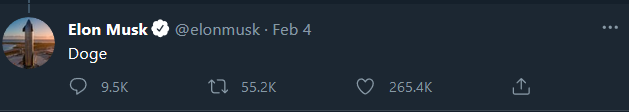

## The media went completely nuts

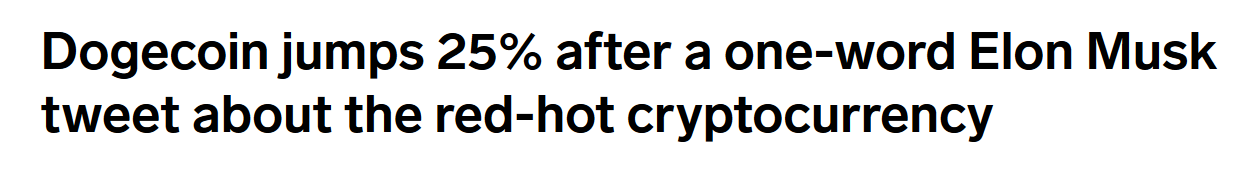


### <center> During the time I scraped tweets, the price did this:</center>

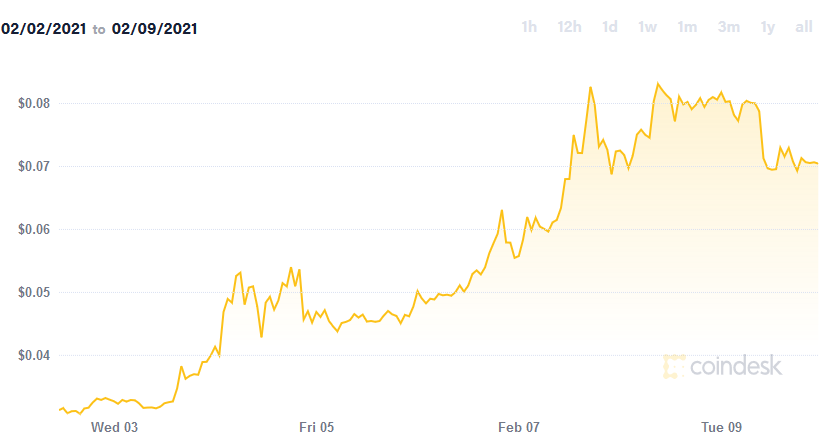


### Did Elon Musk Tweeting really effect Doge Coin that much?

How would you answer this question?

Assume that the only data you have is:
- Tweets streamed from Twitter for a four day period (looking for tweets with "#doge").
- Elon Musk tweets from that same period.
- Doge coin prices (daily).

## <center> discuss </center>

## Discuss your strategy
BUT...
1. Don't use math.
2. Don't use econometric terminology.
3. Specify what you would output.

### So let's get into it!
but first...
## Data cleaning
My stream outputted tweets as they came in. I captured them by piping the output to a .txt file. Specifically, I ran this command from bash:

`python doge_stream.py > doge_tweets.txt`

What I got was several json objects separated by blank spaces.

### `sed` expressions
To clean these files, I am using two "sed" expressions that remove blank whitespace and make it a proper json file.
- `/^[[:space:]]*$/d` 
    - This one deletes lines that have only white space on them.
- `1s/^/[/;$!s/$/,/;$s/$/]/` 
    - This one puts a comma at the end of each line and brackets it with \[ and \]

In [ ]:
for file in glob.glob(dir_+"doge*.txt"):
    temp_file = open(dir_+"temp", "w")
    out_file = open(dir_+file.split("\\")[1].split(".")[0] + ".json", "a")
    sub = subprocess.call(['sed', '/^[[:space:]]*$/d',file], stdout=temp_file )
    sub = subprocess.call(['sed', '1s/^/[/;$!s/$/,/;$s/$/]/' , dir_+"temp"], stdout=out_file )

Now let's find them all using `glob` and put them into one dictionary

In [4]:
json_doge_files = glob.glob(dir_+"doge*.json")

file_dict={}
for file in json_doge_files:
    print(file)
    with open(file) as f:
        tweets = json.load(f)
    file_dict[file] = tweets

../../Data/Text\doge_tweets.json
../../Data/Text\doge_tweets2.json
../../Data/Text\doge_tweets3.json
../../Data/Text\doge_tweets4.json
../../Data/Text\doge_tweets6.json


In [5]:
tweet_list = []
for x in file_dict.values():
    tweet_list += x

In [6]:
len(tweet_list)

1600756

Now I will write them to one json file

In [ ]:
with open("doge_tweets_all.json","w") as f:
    json.dump(tweet_list,f)

Now let's make it into one DataFrame!

In [ ]:
df = pd.DataFrame()

df['time_stamp'] = [x['created_at'] for x in tweet_list]
df['time_stamp'] = pd.to_datetime(df.time_stamp)
df['minute'] = df['time_stamp'].map(lambda x: str(x)[:16])


An issue with the text field...

Because I didn't use the "extended tweet" option in the stream, if the text is too long it is stored in another place.

- If it is a retweet, it is stored in "retweeted_status."
    - If the tweet is too long, it is then stored in "extended_tweet."
    - Else it is in a field called "text."
- Else if it is a long tweet it is stored in "extended_tweet."
- Else it is stored in "text."

In [ ]:
ext_text = []

for tweet in tweet_list:
    if "retweeted_status" in list(tweet.keys()): # Is one of the keys "retweeted_status"
        if "extended_tweet" in list(tweet['retweeted_status'].keys()): # Is one of they keys in "extended tweet"
            ext_text += [tweet['retweeted_status']['extended_tweet']['full_text']]
        else:
            ext_text += [tweet['retweeted_status']['text']] # If not, take "text"
    elif "extended_tweet" in list(tweet.keys()): # Is one of the keys "extended_tweet"
        ext_text += [tweet['extended_tweet']['full_text']]
    else:
        ext_text += [tweet['text']] # If not, take "text"

df['text'] = ext_text

Created some more columns.

In [ ]:
df['RT'] = ["retweeted_status" in list(x.keys()) for x in tweet_list]

df['user_name'] = [x['user']['screen_name'] for x in tweet_list]

df['retweet_user'] = [x['retweeted_status']['user']['screen_name'] # Need if-else to keep length.
                           if "retweeted_status" in list(x.keys())
                           else None 
                       for x in tweet_list]

Here I can grab the location of the Tweet.

In [ ]:
df['location'] = [x['user']['location'] for x in tweet_list]
df['retweet_location'] = [x['retweeted_status']['user']['location'] 
                           if "retweeted_status" in list(x.keys())
                           else None
                      for x in tweet_list]

### Word Counts
First let's clean the text in the usual way.


In [ ]:
df['clean_text'] = [unidec(x).lower().replace("’","")\
                             .replace(",","")\
                             .replace("\n"," ") if type(x) is str else None for x in df['text']]

df = df[~pd.isnull(df.text)]

df.to_csv("doge_tweets.csv",index=False)

This dataset is very big, so I'll write out a temporary copy here.

In [7]:
df = pd.read_csv("doge_tweets.csv")
df = df[~pd.isnull(df.clean_text)]
df = df[~pd.isnull(df.text)]

df['time_stamp_ct'] = pd.to_datetime(df['time_stamp']) - timedelta(hours=6)

In [50]:
df = df[~pd.isnull(df.clean_text)]
df = df[~pd.isnull(df.text)]

I am going to use an sklean vectorizer here, only because my usual approach is too memory intensive.

Part of the reason sklearn is more efficient in this case is that it uses __sparse matrices__ to do the computations.

In [8]:
vct = CountVectorizer(stop_words="english")

X = vct.fit_transform(list(df['clean_text']))

In [9]:
X

<1598855x329356 sparse matrix of type '<class 'numpy.int64'>'
	with 16782239 stored elements in Compressed Sparse Row format>

This matrix currently holds 16 million entries, but somehow does it efficiently. How?

### Sparse Matrices
- Matrices were most of the elements are zero.
- If you are using int64, its taking up 64 bits just to put zeros. What a waste!
- One format is called __Compressed Sparse Row__ and holds this data more efficiently. From the Wikipedia page:
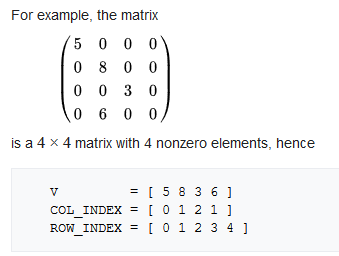
    Holding three one-dimensional arrays is much more efficient than a giant two-dimensional array.

A handy feature here is that you can still do normal operations on a sparse matrix. I will sum it and then make it a dataframe:

In [10]:
word_counts = pd.DataFrame(X.sum(axis=0))

I can label columns by extracting the "feature names"

In [11]:
word_counts.columns = vct.get_feature_names()
word_counts = word_counts.T

So here are the top 5 words:

In [12]:
word_counts = word_counts[0].sort_values(ascending=False)
word_counts.head()

dogecoin    1345662
doge         969534
https        741129
dogearmy     476559
elonmusk     231025
Name: 0, dtype: int64

I'm going to take out the first two because they were in the query I asked for (and so should be in practically every Tweet!)

In [13]:
words =  list(word_counts.index)

# Note that these are in-place operations.
words.remove("https")
words.remove("dogecoin")
words.remove("doge")

word_counts = word_counts.loc[words]

In [14]:
word_counts.head(20)

dogearmy             476559
elonmusk             231025
dogecointothemoon    226552
retweet              164254
dogecoinarmy         150955
buy                  147260
bitcoin              146022
dogecoinrise         145829
let                  139198
crypto               100293
hold                  99609
dogetoadollar         96834
amp                   90240
rt                    87077
like                  86408
moon                  84902
just                  84251
10                    80713
dogecoins             79409
dogetothemoon         77027
Name: 0, dtype: int64

### Which of these are hashtags?
How shall we find hashtags?

How you extract them is an exercise for you 

__(but here's a hint: CountVectorizer accepts regular expression...)__

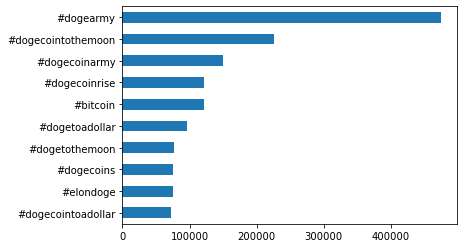

In [13]:
pd.read_csv("top_hashtags.csv",index_col=0)["0"].sort_values(ascending=True)[:-2].tail(10).plot(kind='barh')

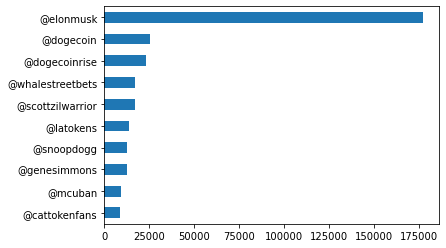

In [14]:
pd.read_csv("top_mentions.csv",index_col=0)["0"].sort_values(ascending=True).tail(10).plot(kind='barh')

### Sentiment Analysis

In [15]:
sid = SentimentIntensityAnalyzer()

df['sentiment_score'] = [sid.polarity_scores(x)['compound'] for x in df['text']]

df = df.sort_values("time_stamp_ct").drop_duplicates()

(array([737824., 737825., 737826., 737827., 737828., 737829.]),
 <a list of 6 Text major ticklabel objects>)

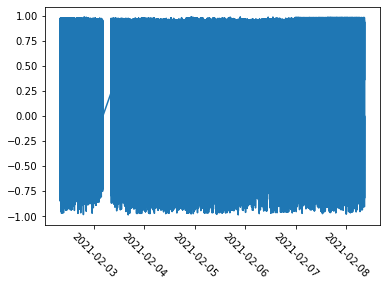

In [18]:
f,a = plt.subplots()

a.plot(df.time_stamp_ct,df.sentiment_score)
plt.xticks(rotation=-45)

In [46]:
df.time_stamp.head(40)

46475    2021-02-02 14:08:59+00:00
0        2021-02-02 14:10:12+00:00
46110    2021-02-02 14:10:13+00:00
46111    2021-02-02 14:10:13+00:00
92221    2021-02-02 14:10:16+00:00
92223    2021-02-02 14:10:16+00:00
92224    2021-02-02 14:10:16+00:00
92225    2021-02-02 14:10:16+00:00
46113    2021-02-02 14:10:16+00:00
92226    2021-02-02 14:10:18+00:00
46119    2021-02-02 14:10:18+00:00
92227    2021-02-02 14:10:18+00:00
11       2021-02-02 14:10:19+00:00
12       2021-02-02 14:10:20+00:00
46122    2021-02-02 14:10:21+00:00
46123    2021-02-02 14:10:21+00:00
46125    2021-02-02 14:10:23+00:00
46124    2021-02-02 14:10:23+00:00
92235    2021-02-02 14:10:23+00:00
46127    2021-02-02 14:10:24+00:00
46128    2021-02-02 14:10:25+00:00
92240    2021-02-02 14:10:26+00:00
92239    2021-02-02 14:10:26+00:00
92238    2021-02-02 14:10:26+00:00
23       2021-02-02 14:10:27+00:00
46133    2021-02-02 14:10:27+00:00
46136    2021-02-02 14:10:28+00:00
46135    2021-02-02 14:10:28+00:00
46134    2021-02-02 

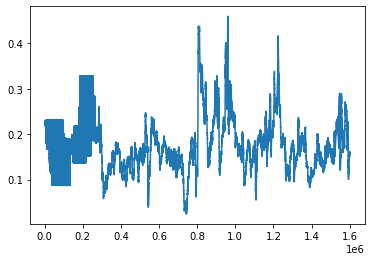

In [43]:
df.sentiment_score.rolling(3600).mean().plot()

... good?

### Creating a minute and hour grouping variable

In [51]:
df['minute_ct'] = pd.to_datetime(df['time_stamp_ct'].map(lambda x: str(x)[:-9]) +":00")
df['hour_ct'] = pd.to_datetime(df['time_stamp_ct'].map(lambda x: str(x)[:-11]) +"00:00")


Text(0.5, 1.0, 'Tweet Sentiment about Doge and Dogecoin')

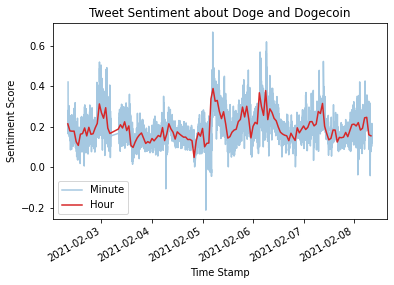

In [52]:
f, a = plt.subplots()
df.groupby("minute_ct").sentiment_score.mean().plot(alpha=.4,label="Minute")
df.groupby("hour_ct").sentiment_score.mean().plot(color="C3",label="Hour")
plt.legend(loc="lower left")
plt.xlabel("Time Stamp")
plt.ylabel("Sentiment Score")
plt.title("Tweet Sentiment about Doge and Dogecoin")

Text(0.5, 1.0, 'Tweet Volume about Doge and Dogecoin')

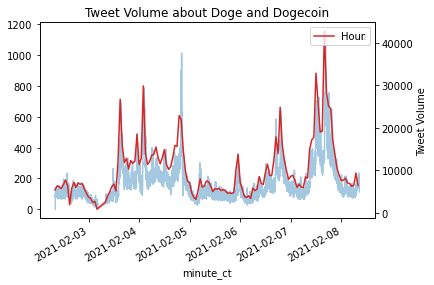

In [24]:
f, a = plt.subplots()
df.groupby("minute_ct").sentiment_score.count().plot(alpha=.4,label="Minute",ax=a)
plt.legend("upper left")

a2 = a.twinx()
df.groupby("hour_ct").sentiment_score.count().plot(color="C3",label="Hour",ax=a2)
plt.legend(loc="upper right")
plt.xlabel("Time Stamp")
plt.ylabel("Tweet Volume")
plt.title("Tweet Volume about Doge and Dogecoin")

Which one should we work with?

Hour 
- Pro: A data for every time unit, not as sensitive to outliers.
- Con: Misses realtime reactions.

Minute
- Pro: Observes real time feedback and short-term movements, the most clear.
- Con: Will have no obs where nobody tweeted anything.

From here on, I'll use hour because its easier.

Text(0.5, 1.0, 'Tweet Sentiment vs. Tweet Volume')

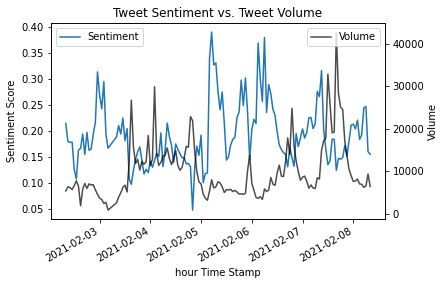

In [53]:
f, a = plt.subplots()
df.groupby("hour_ct").sentiment_score.mean().plot(alpha=1,label="Sentiment",ax=a)
plt.legend(loc="upper left")

a2 = a.twinx()
df.groupby("hour_ct").sentiment_score.count().plot(alpha=.7,color="black",label="Volume",ax=a2)
plt.legend(loc="upper right")
# plt.xlabel("Time Stamp")
a.set_ylabel("Sentiment Score")
a.set_xlabel("hour Time Stamp")
a2.set_ylabel("Volume")
plt.title("Tweet Sentiment vs. Tweet Volume")

In [54]:
cor = pd.DataFrame()
cor['sent'] = df.groupby("hour_ct").sentiment_score.mean()
cor['vol'] = df.groupby("hour_ct").sentiment_score.count()
cor.corr()

,sent,vol
sent,1.000000,-0.465075
vol,-0.465075,1.000000


## Other Data Sources
### Elon Musk tweets

In [55]:
with open("Elon_tweets.json","r") as f:
    elon = json.load(f)

Data cleaning

In [56]:
elon_df = pd.DataFrame()

elon_df['time_stamp'] = [x['created_at'] for x in elon]
elon_df['time_stamp_ct'] = pd.to_datetime(elon_df.time_stamp) - timedelta(hours=6)
elon_df['hour_ct'] = pd.to_datetime(elon_df['time_stamp_ct'].map(lambda x: str(x)[:-11]) +"00:00")

In [57]:
ext_text = []

for tweet in elon:
    if "retweeted_status" in list(tweet.keys()):
        if "extended_tweet" in list(tweet['retweeted_status'].keys()):
            ext_text += [tweet['retweeted_status']['extended_tweet']['full_text']]
        else:
            ext_text += [tweet['retweeted_status']['text']]
    elif "extended_tweet" in list(tweet.keys()):
        ext_text += [tweet['extended_tweet']['full_text']]
    else:
        ext_text += [tweet['full_text']]
        
elon_df['text'] = ext_text


In [58]:
elon_df['RT'] = ["retweeted_status" in list(x.keys()) for x in elon]

elon_df['retweet_user'] = [x['retweeted_status']['user']['screen_name'] 
                           if "retweeted_status" in list(x.keys())
                           else None 
                      for x in elon]

elon_df['retweet_location'] = [x['retweeted_status']['user']['location'] 
                                   if "retweeted_status" in list(x.keys())
                                   else None
                              for x in elon]

Only look at Elon tweets from our time period.

In [60]:
max_time = df['time_stamp_ct'].max()
min_time = df['time_stamp_ct'].min()

elon_df = elon_df[(elon_df.time_stamp_ct<max_time)&(elon_df.time_stamp_ct>min_time)]

#### Summarize by hour
Here I'm using simply the number of times he tweeted.

In [62]:
elon_hourly_sum = (elon_df.groupby('hour_ct')['text'].count()).astype(int)
elon_hourly_sum = elon_hourly_sum.replace(0,np.nan)

Now let's look:

In [64]:
%matplotlib notebook

<IPython.core.display.Javascript object>


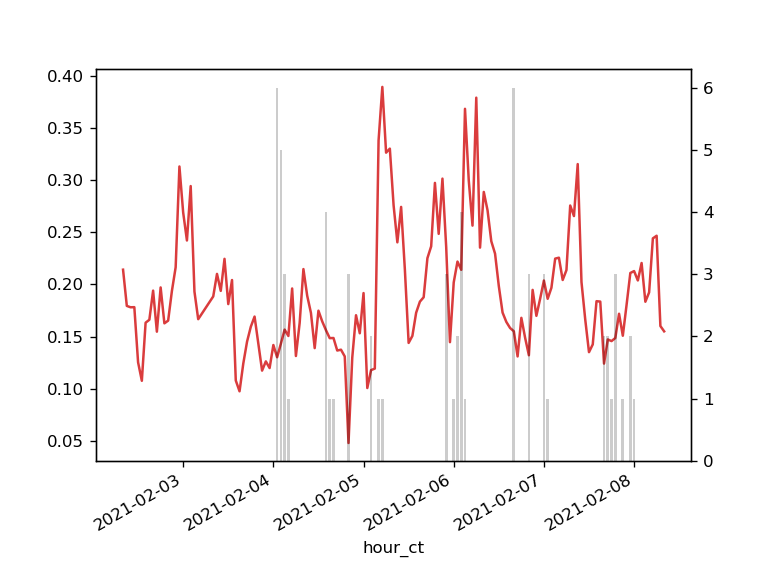

<BarContainer object of 27 artists>

In [69]:
f,a =plt.subplots()
df.groupby('hour_ct')['sentiment_score'].mean().plot(ax=a,color="C3",alpha=.9)
# df.groupby('hour_ct')['sentiment_score'].count().plot(ax=a,color="C0",alpha=.9)

a2 = a.twinx()
plt.bar(elon_hourly_sum.index,elon_hourly_sum,color="black",alpha=.2,width=.03)
# plt.xlim(pd.to_datetime("2021-02-04"),pd.to_datetime("2021-02-06"))

In [70]:
hour_data = df.groupby('hour_ct')[['sentiment_score']].mean().join(elon_hourly_sum).fillna(0)

In [73]:
hour_data['l1_elon'] = hour_data['text'].shift(1)
hour_data['l2_elon'] = hour_data['text'].shift(2)

hour_data['l1_sent'] = hour_data["sentiment_score"].shift(1)
hour_data['l2_sent'] = hour_data["sentiment_score"].shift(2)

In [74]:
reg(hour_data,"sentiment_score",["text","l1_elon","l1_sent","l2_elon","l2_sent"],addcons=True)

Dependent variable:	sentiment_score
N:			140
R-squared:		0.4875
Estimation method:	OLS
VCE method:		Standard (Homosk.)
         coeff    se      t   p>t CI_low CI_high
text    -0.003 0.003 -0.902 0.369 -0.010   0.004
l1_elon  0.002 0.004  0.460 0.646 -0.005   0.009
l1_sent  0.637 0.086  7.440 0.000  0.468   0.806
l2_elon  0.004 0.003  1.288 0.200 -0.002   0.011
l2_sent  0.079 0.087  0.917 0.361 -0.092   0.251
_cons    0.053 0.015  3.641 0.000  0.024   0.082

What's the problem with this method?

Let's try another method, more like RDD.

In [76]:
def dog_bandwidth(time,band_minutes):
    upper_bound = time_of_doge + timedelta(minutes=band_minutes)
    lower_bound = time_of_doge - timedelta(minutes=band_minutes)
    new_df = df[(df.time_stamp_ct>lower_bound)&(df.time_stamp_ct<upper_bound)]
    new_df['cutoff'] = new_df['time_stamp_ct']>=time
    return new_df

In [77]:
time_of_doge = elon_df.loc[189]['time_stamp_ct']

<ipython-input-76-0edb0eef66fa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cutoff'] = new_df['time_stamp_ct']>=time


<IPython.core.display.Javascript object>


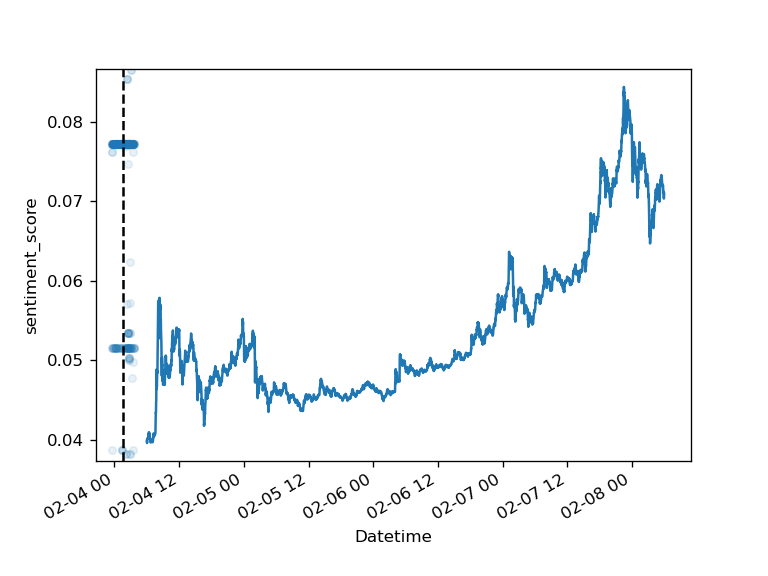

(array([737824.97916667, 737825.        , 737825.02083333, 737825.04166667,
        737825.0625    , 737825.08333333, 737825.10416667, 737825.125     ,
        737825.14583333]),
 <a list of 9 Text major ticklabel objects>)

In [83]:
df_10 = dog_bandwidth(time_of_doge,120)
df_10[['time_stamp_ct','sentiment_score']].plot(kind='scatter',x="time_stamp_ct",y="sentiment_score",alpha=.1)
plt.axvline(time_of_doge,color="black",ls="--")
plt.xticks(rotation=-45)

### Doge Coin Prices

In [84]:
doge_prices = pd.read_csv(dir_ + "such_data.csv")

In [85]:
doge_prices['time_stamp'] = pd.to_datetime(doge_prices['Date'])

In [86]:
doge_prices

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),time_stamp
0,DOGE,1/25/2021,0.008342,0.008824,0.008861,0.008165,2021-01-25
1,DOGE,1/26/2021,0.008000,0.008350,0.008411,0.007965,2021-01-26
2,DOGE,1/27/2021,0.013387,0.008067,0.014411,0.007250,2021-01-27
3,DOGE,1/28/2021,0.064854,0.012506,0.079225,0.010248,2021-01-28
4,DOGE,1/29/2021,0.034067,0.061681,0.069670,0.028235,2021-01-29
5,DOGE,1/30/2021,0.027314,0.031762,0.038259,0.022180,2021-01-30
6,DOGE,1/31/2021,0.040456,0.028896,0.046238,0.027262,2021-01-31
7,DOGE,2/1/2021,0.033307,0.040735,0.043795,0.030252,2021-02-01
8,DOGE,2/2/2021,0.032637,0.033567,0.035306,0.030194,2021-02-02
9,DOGE,2/3/2021,0.041284,0.032496,0.043432,0.031041,2021-02-03


<IPython.core.display.Javascript object>


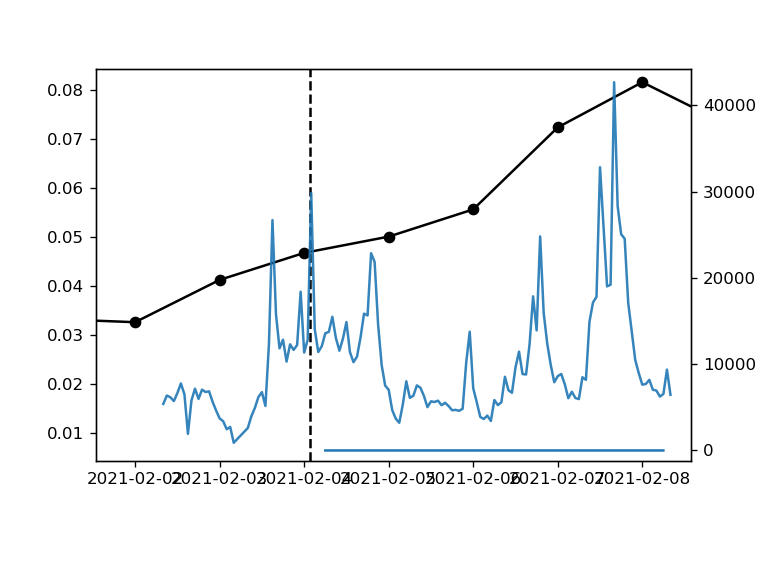

In [89]:
f,a = plt.subplots()
a.plot(doge_prices.time_stamp,doge_prices['Closing Price (USD)'],marker="o",color="black")
a2 = a.twinx()
df.groupby('hour_ct')['sentiment_score'].count().plot(ax=a2,color="C0",alpha=.9)
a.axvline(time_of_doge,color='black',ls='--')

# plt.xlim(min_time,max_time)


### Downloading minute data

In [91]:
import yfinance as yf

In [106]:
doge_coin = yf.download(tickers='DOGE-USD', start='2021-01-29', end='2021-02-09', interval='2m')

[*********************100%***********************]  1 of 1 completed
